In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
num_imgs = 50000

img_size = 16
min_rect_size = 3
max_rect_size = 8
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            imgs[i_img, x:x+width, y:y+height] = 1.  #???
            bboxes[i_img, i_object] = [x, y, width, height]
            shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size=2)
            mask = np.tril_indices(size)  #provide triangle...
            
            
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
            bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]
        
imgs.shape, bboxes.shape

((50000, 16, 16), (50000, 2, 4))

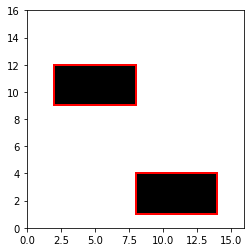

In [3]:
i = 0
# TODO: Why does the array have to be transposed?
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox, shape in zip(bboxes[i], shapes[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec='r' if shape[0] == 0 else 'y', fc='none'))

In [4]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 256), -4.842182210751389e-17, 1.0000000000000007)

In [5]:
# TODO: We use binary classification here - for multiple classes, convert classes to one-hot vectors.
y = np.concatenate([bboxes / img_size, shapes], axis = -1).reshape(num_imgs, -1)
#print(y[:3])

[[0.125  0.5625 0.375  0.1875 0.     0.5    0.0625 0.375  0.1875 0.    ]
 [0.125  0.25   0.3125 0.4375 0.     0.125  0.     0.3125 0.3125 1.    ]
 [0.625  0.1875 0.3125 0.4375 0.     0.375  0.1875 0.375  0.3125 0.    ]]


In [6]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]
#print(train_y[:3])

[[0.125  0.5625 0.375  0.1875 0.     0.5    0.0625 0.375  0.1875 0.    ]
 [0.125  0.25   0.3125 0.4375 0.     0.125  0.     0.3125 0.3125 1.    ]
 [0.625  0.1875 0.3125 0.4375 0.     0.375  0.1875 0.375  0.3125 0.    ]]


In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
model = Sequential([
        Dense(256, input_dim = X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.6), 
        Dense(y.shape[-1])
    ])
#model.compile('adadelta', 'mse')#by author
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])#by Clio
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 68,362
Trainable params: 68,362
Non-trainable params: 0
_________________________________________________________________


In [8]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    w_I = max(w_I, 0)  # set w_I and h_I zero if there is no intersection
    h_I = max(h_I, 0)
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

In [9]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

In [46]:
# Flip bboxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 

num_epochs = 15
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious = np.zeros((len(flipped_train_y), num_epochs))
dists = np.zeros((len(flipped_train_y), num_epochs))
shape_accuracy = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print ('Epoch: ', epoch)
    model.fit(train_X, flipped_train_y, epochs = 1, validation_data = (test_X, test_y), verbose = 2,
              callbacks = [ModelCheckpoint('Two_Rectangles_or_Triangles_model.h5',
                                           monitor = 'val_loss',
                                           save_best_only = True)])
    pred_y = model.predict(train_X)

    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        flipped_exp_bboxes = np.concatenate([exp_bboxes[5:], exp_bboxes[:5]])
        #if i < 3:
        #    print("flipped_exp_bboxes = \n", flipped_exp_bboxes, "\nexp_bboxes = \n", exp_bboxes)
        #    print("exp_bboxes", exp_bboxes, "\n", exp_bboxes[0:4])
        #    print("flipped_exp_bboxes: ", flipped_exp_bboxes, "\n", flipped_exp_bboxes[1:5])
        mse = np.mean(np.square(pred_bboxes[0:4] - exp_bboxes[0:4]) + np.square(pred_bboxes[5:9] - exp_bboxes[5:9]))
        mse_flipped = np.mean(np.square(pred_bboxes[0:4] - flipped_exp_bboxes[0:4]) + np.square(pred_bboxes[5:9] - flipped_exp_bboxes[5:9]))
        
        #if i < 3:
        #    print("mse = ", mse, "\nmse_flipped = ", mse_flipped)
        iou = IOU(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[5:], exp_bboxes[5:])
        iou_flipped = IOU(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[5:], flipped_exp_bboxes[5:])
        
        dist = distance(pred_bboxes[:4], exp_bboxes[:4]) + distance(pred_bboxes[5:], exp_bboxes[5:])
        dist_flipped = distance(pred_bboxes[:4], flipped_exp_bboxes[:4]) + distance(pred_bboxes[5:], flipped_exp_bboxes[5:])
        #print (pred_bboxes[:3], "\n", exp_bboxes[:3], "\n", dist)
        #if i < 3:
        #    print("pred_bboxes[:4] = ", pred_bboxes[:4], "\t[5:9] = ", pred_bboxes[5:9])
        #    print("exp_bboxes[:4] = ", exp_bboxes[:4], "\t[5:9] = ", exp_bboxes[5:9])
        #    print("flipped_exp_bboxes[:4] = ", flipped_exp_bboxes[:4], " flipped_exp_bboxes[5:] = ", flipped_exp_bboxes[5:])
        
        shape = np.sqrt(np.square(pred_bboxes[4] - exp_bboxes[4]) + np.square(pred_bboxes[9] - exp_bboxes[9]))
        shape_flipped = np.sqrt(np.square(pred_bboxes[4] - exp_bboxes[4]) + np.square(pred_bboxes[9] - flipped_exp_bboxes[9]))
        
        if mse_flipped < mse:  # using iou or dist here leads to similar results
            flipped_train_y[i] = flipped_exp_bboxes
            flipped[i, epoch] = 1
            ious[i, epoch] = iou_flipped / 2.
            dists[i, epoch] = dist_flipped / 2.
            shape_accuracy[i, epoch] = shape_flipped
        else:
            ious[i, epoch] = iou / 2.
            dists[i, epoch] = dist / 2.
            shape_accuracy[i, epoch] = shape
            
        #print("------------------------------")
    print ('Flipped {} training samples ({} %)'.format(np.sum(flipped[:, epoch]), np.mean(flipped[:, epoch]) * 100.))
    print ('Mean IOU: {}'.format(np.mean(ious[:, epoch])))
    print ('Mean dist: {}'.format(np.mean(dists[:, epoch])))
    print ('shape detect: {}'.format(np.mean(shape_accuracy[:, epoch])))

Epoch:  0
1250/1250 - 2s - loss: 0.0479 - accuracy: 0.3632 - val_loss: 0.0420 - val_accuracy: 0.4267
Flipped 19705.0 training samples (49.262499999999996 %)
Mean IOU: 0.27533989721867586
Mean dist: 0.17884397090489723
shape detect: 0.46679507164321893
Epoch:  1
1250/1250 - 2s - loss: 0.0427 - accuracy: 0.4657 - val_loss: 0.0457 - val_accuracy: 0.3633
Flipped 8153.0 training samples (20.3825 %)
Mean IOU: 0.3372477302173392
Mean dist: 0.1444781528768479
shape detect: 0.43981482590177057
Epoch:  2
1250/1250 - 2s - loss: 0.0380 - accuracy: 0.5170 - val_loss: 0.0490 - val_accuracy: 0.4414
Flipped 4785.0 training samples (11.9625 %)
Mean IOU: 0.386063839899706
Mean dist: 0.12625972356246573
shape detect: 0.40968929154578293
Epoch:  3
1250/1250 - 2s - loss: 0.0349 - accuracy: 0.5563 - val_loss: 0.0513 - val_accuracy: 0.3900
Flipped 2453.0 training samples (6.132499999999999 %)
Mean IOU: 0.4054743299846854
Mean dist: 0.11729251434563912
shape detect: 0.3832157710203832
Epoch:  4
1250/1250 - 2s

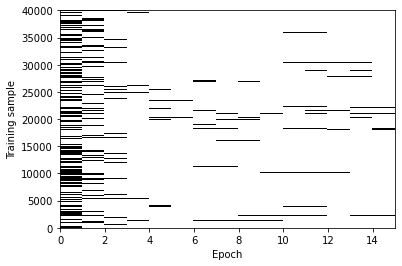

In [63]:
plt.pcolor(flipped[:, :], cmap='Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')

plt.savefig('two-rectangles-or-triangles_flips.png', dpi = 100)

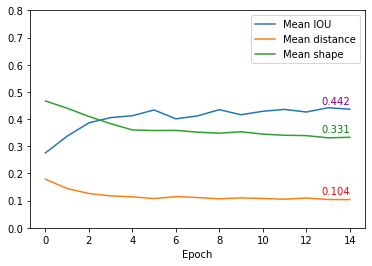

In [64]:
plt.plot(np.mean(ious, axis=0), label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(np.mean(dists, axis=0), label='Mean distance')  # relative to image size
plt.plot(np.mean(shape_accuracy, axis=0), label='Mean shape')

mean_ious_epoch = np.mean(ious, axis = 0)
mean_dists_epoch = np.mean(dists, axis = 0)
mean_shape_epoch = np.mean(shape_accuracy, axis = 0)

plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch) - 1, mean_ious_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'purple')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch) - 1, mean_dists_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'r')
plt.annotate(np.round(np.min(mean_shape_epoch), 3), (len(mean_shape_epoch) - 1, mean_shape_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'g')

#ax = plt.gca()
#ax.axes.yaxis.set_visible(False)

plt.legend()
plt.xlabel('Epoch')
plt.ylim(0, 0.8)

plt.savefig('two-rectangles-or-triangles_training_metrics.png', dpi = 100)

In [65]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

((10000, 2, 4), (10000, 2, 1))

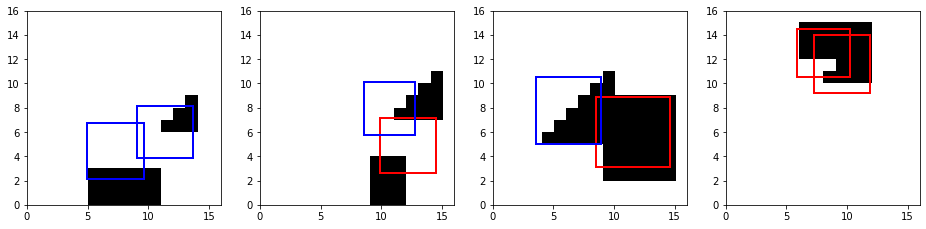

In [66]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], lw = '2', ec='r' if pred_shape[0] <= 0.5 else 'b', fc='none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')

plt.savefig('two-rectangles-or-triangles-results.png', dpi=300)

In [67]:
from keras.models import load_model
model_test =  load_model("Two_Rectangles_or_Triangles_model.h5")
pred_y = model_test.predict(test_X)
summed_IOU = 0.


for pred_bbox, test_bbox in zip(pred_y, test_y):
    iou = IOU(pred_bbox[:4], test_bbox[:4]) + IOU(pred_bbox[5:], test_bbox[5:])
    iou_flipped = IOU(pred_bbox[:4], test_bbox[5:]) + IOU(pred_bbox[5:], test_bbox[:4])
    
    if iou > iou_flipped:
        summed_IOU += iou
    else:
        summed_IOU += iou_flipped
        
mean_IOU = summed_IOU / (len(pred_bboxes)* num_objects)
mean_IOU

0.43941168057614005